In [ ]:
pip install shap

📂 Please upload your churn dataset (e.g., Customer Churn.csv)


Saving Customer Churn.csv to Customer Churn (2).csv

 Preview of uploaded data (first 5 rows):
   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1            

 99%|===================| 1874/1890 [01:07<00:00]       

SHAP values computed for 945 samples and 13 features.
 Interpretation: Each SHAP value shows how much a feature pushes the prediction toward churn (positive) or retention (negative).

 Building SHAP DataFrame for detailed inspection...

 First 5 rows of SHAP data:
   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0      -0.034377  -0.010402              0.072579        0.030963   
1      -0.078456  -0.021635             -0.031512        0.017495   
2      -0.015058  -0.019297              0.008268        0.025594   
3       0.009785  -0.017528              0.003050        0.012962   
4      -0.080234  -0.013054             -0.016015        0.030786   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0        0.192372          0.162199          0.024207   
1       -0.016954          0.009131         -0.027545   
2       -0.018320         -0.017226          0.041919   
3       -0.051866         -0.034444         -0.008579   
4        0.126001          0.080366

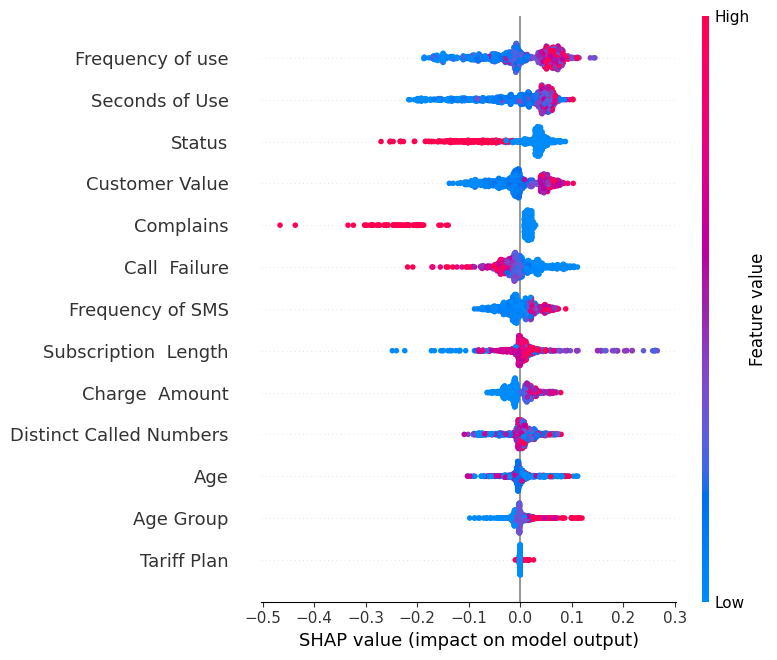

Interpretation: Features pushing predictions left (negative SHAP values) support customer retention.

🟥 Summary Plot for Class 1 (Churn)


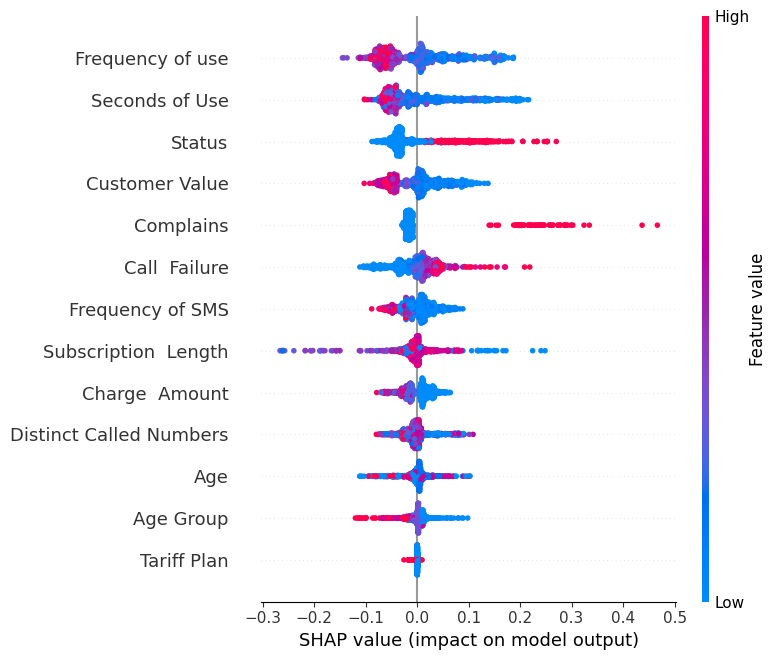

Interpretation: Features pushing predictions right (positive SHAP values) increase churn likelihood.

 Global SHAP Summary – Bar Plot of Mean Absolute SHAP values


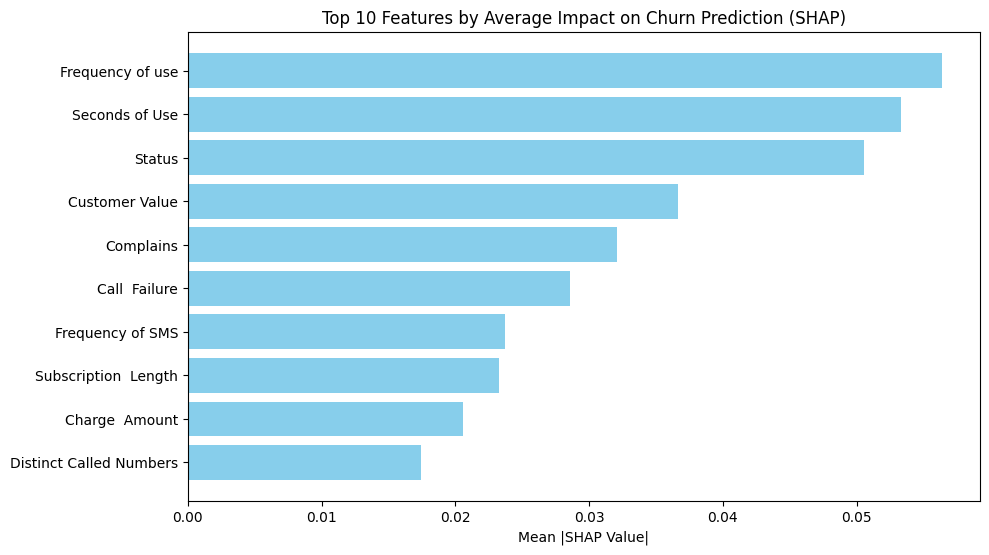

 Interpretation: Features with higher mean |SHAP Value| have a stronger overall influence on the model’s churn predictions, regardless of direction (positive or negative).
 This complements the dot-summary plot by showing magnitude importance in a clear, ranked bar chart format.

 Creating dependence plots to explore nonlinear effects and feature interactions...
Continuous features: ['Call  Failure', 'Subscription  Length', 'Charge  Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']


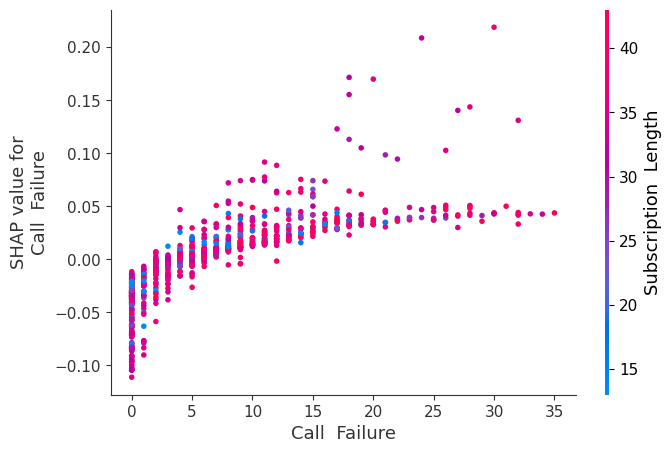

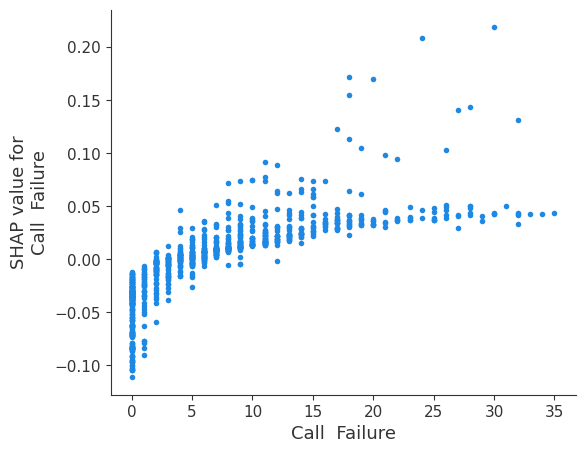


- X-axis = feature value, Y-axis = contribution to churn
- Color shows interacting feature effect
- Nonlinear effects visible (e.g., low Customer Value sharply increases churn risk)
- Business insight: Tailor retention strategies for specific customer segments



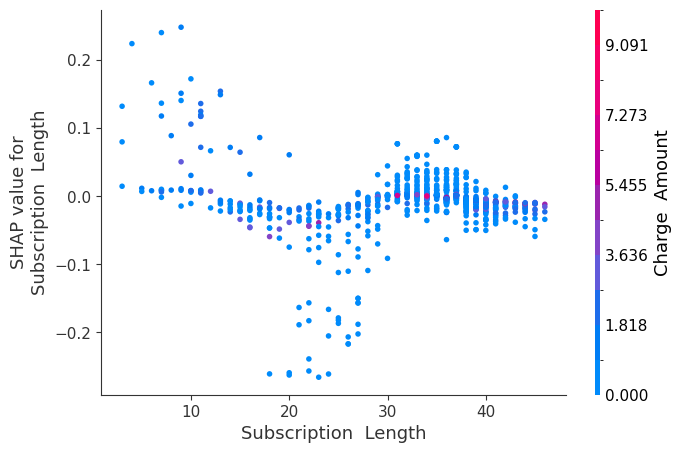

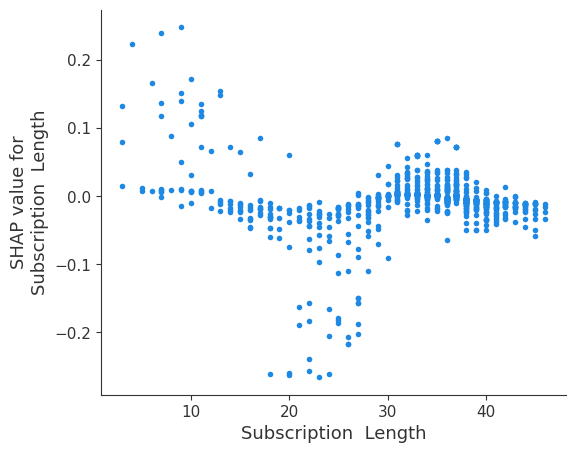


- X-axis = feature value, Y-axis = contribution to churn
- Color shows interacting feature effect
- Nonlinear effects visible (e.g., low Customer Value sharply increases churn risk)
- Business insight: Tailor retention strategies for specific customer segments



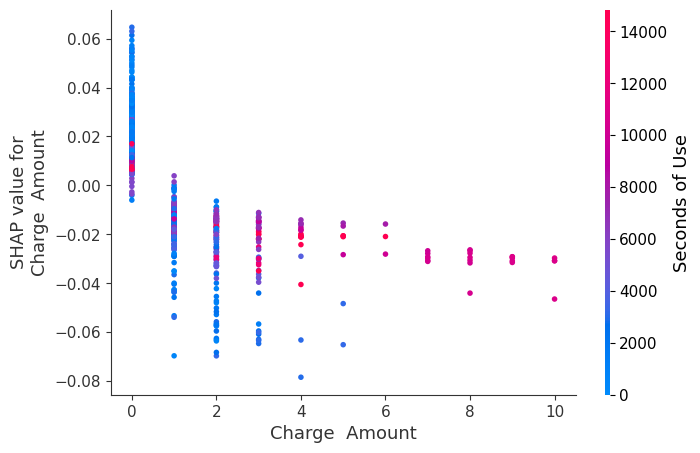

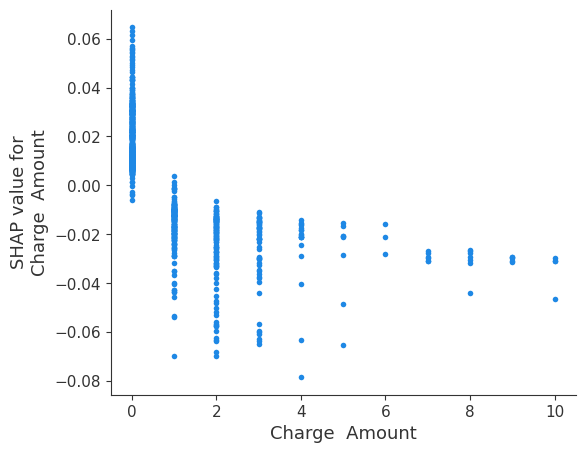


- X-axis = feature value, Y-axis = contribution to churn
- Color shows interacting feature effect
- Nonlinear effects visible (e.g., low Customer Value sharply increases churn risk)
- Business insight: Tailor retention strategies for specific customer segments


 Example 1: Customer predicted *most likely to churn* – waterfall plot shows feature contributions:


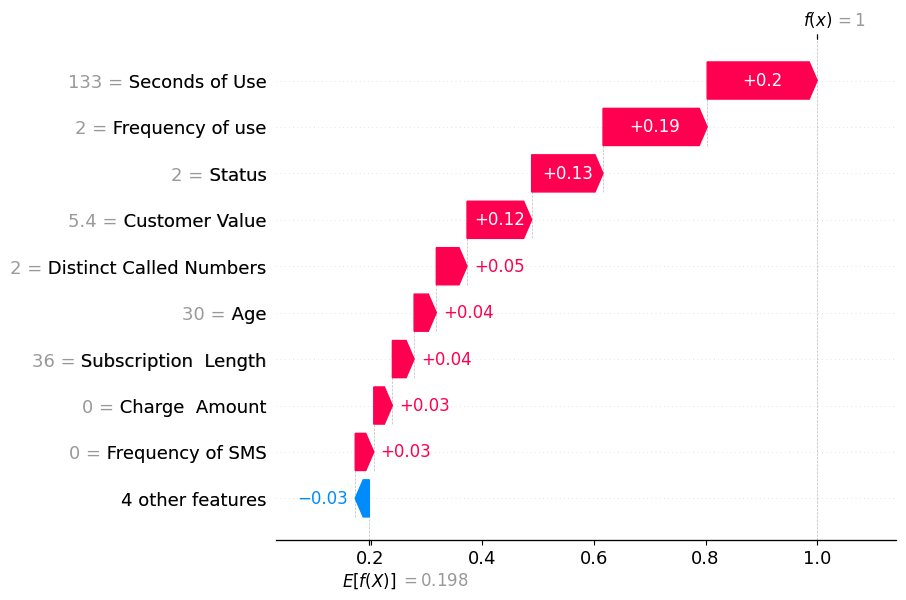


- Positive SHAP values push prediction toward churn; negative values toward retention
- Shows individual customer churn prediction from base value
- Business insight: Use for personalized retention actions


 Example 2: Customer predicted *least likely to churn* – waterfall plot:


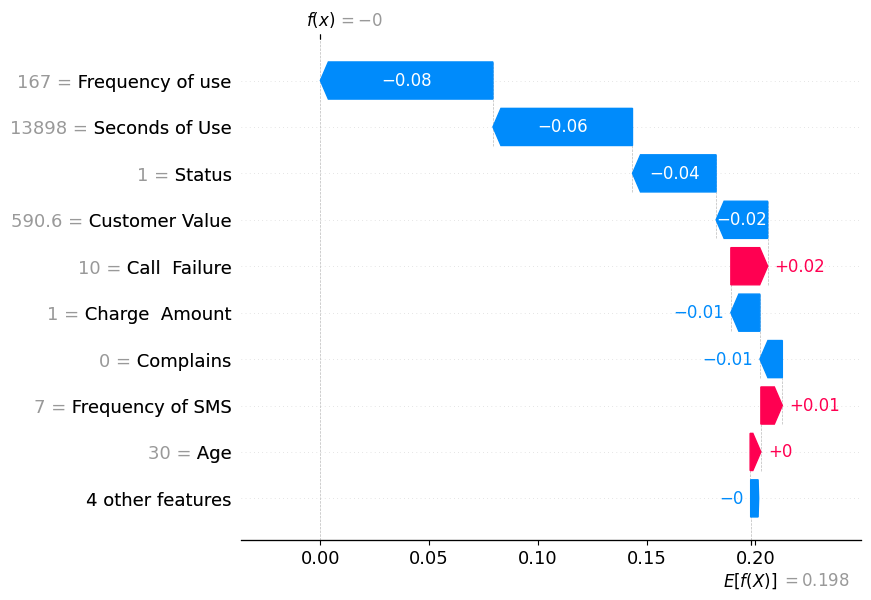


- Features collectively reduced churn probability for this customer
- Arrows right = increase churn, left = decrease churn
- Business insight: Identify customers at low risk to focus resources elsewhere


- Arrows to the right increase predicted churn, arrows left decrease it
- Shows how individual features push this customer's prediction


⚡ Force plot for first customer


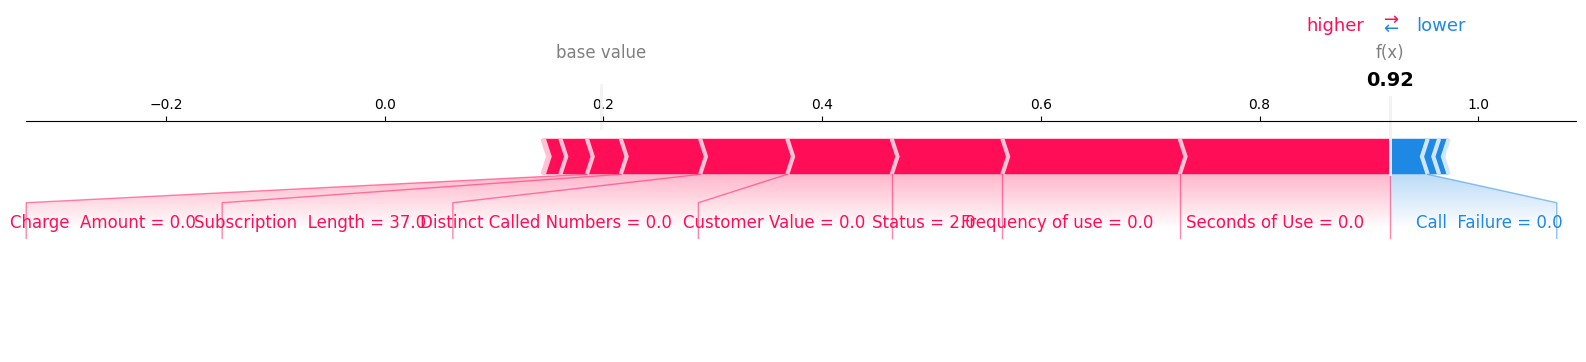

 Interpretation: Arrows to the right increase predicted churn, arrows left decrease it.

⚡ Force plot for seventh customer


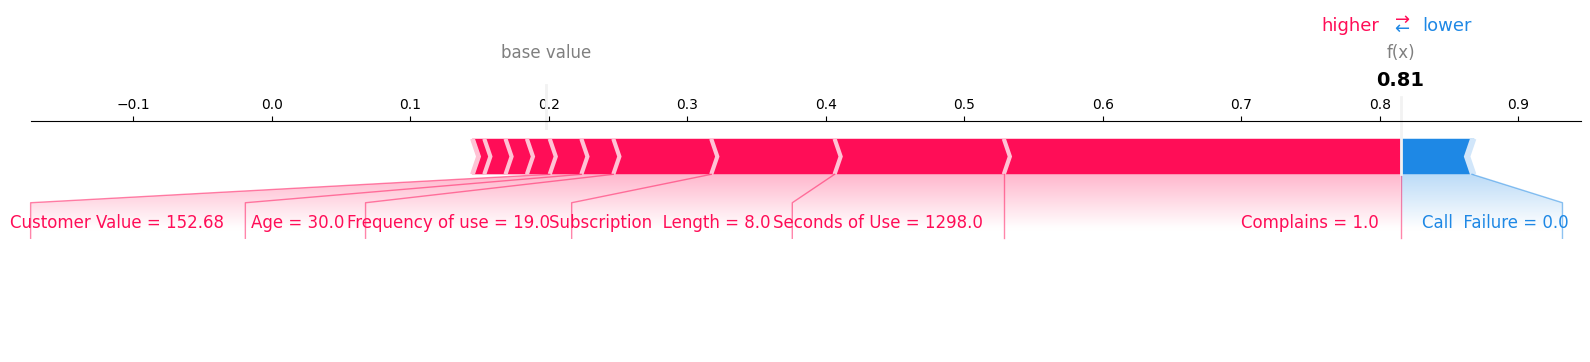


⚡ Force plot for third customer


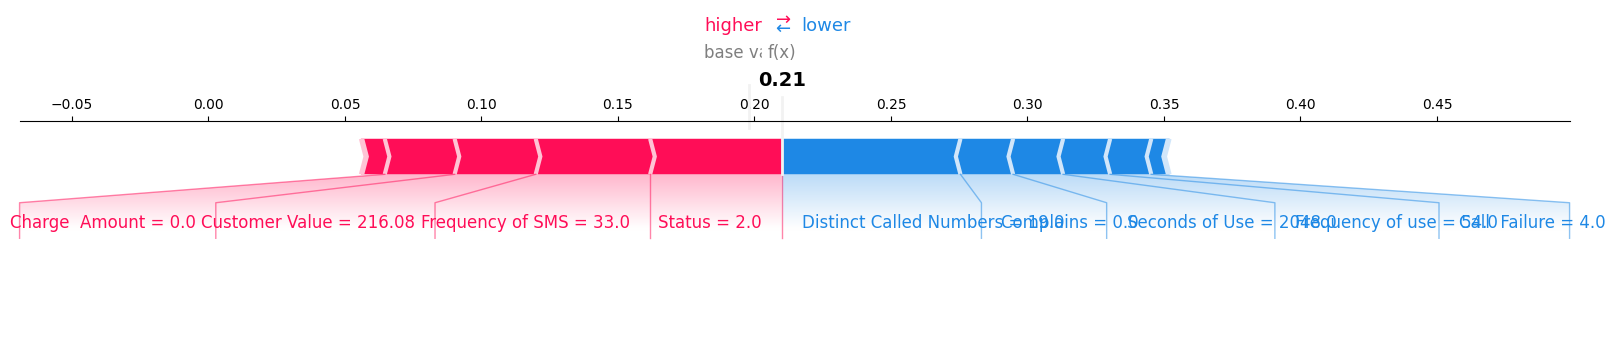

 Interpretation: Shows how individual features push this customer's prediction toward churn or retention.

 Decision Plot – cumulative feature impact for each class

⚡ Decision Plot for 0


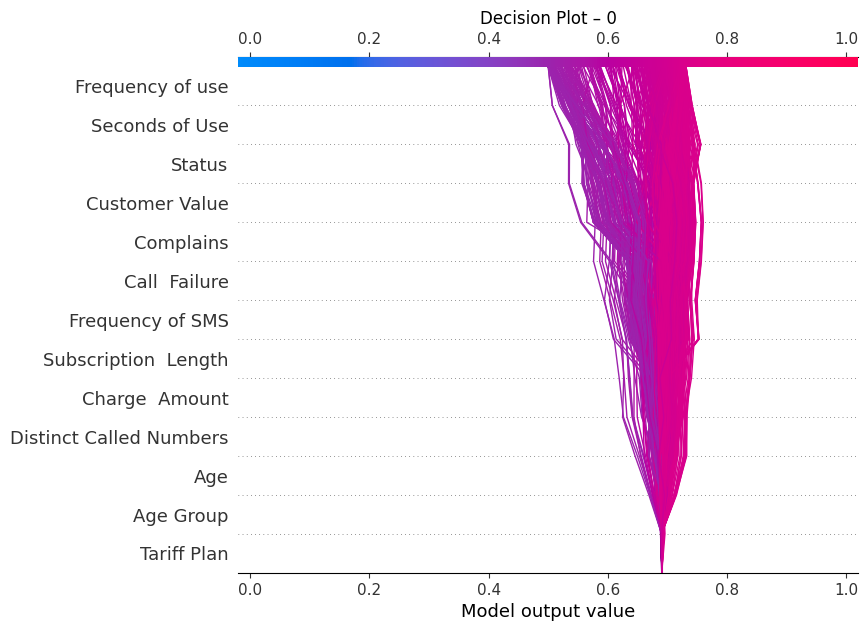

 Interpretation: For 0, this plot shows how features cumulatively push predictions from the base value toward that class’s probability.


⚡ Decision Plot for 1


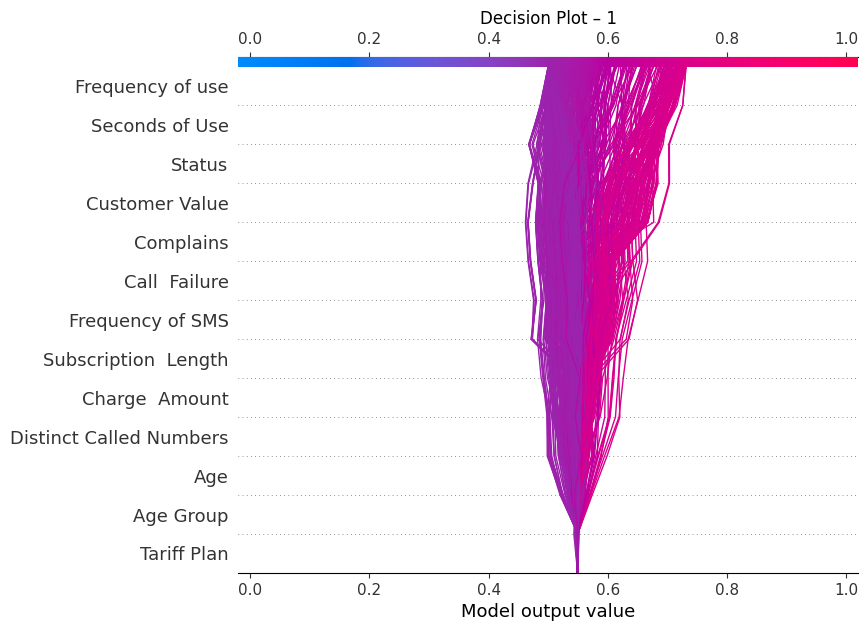

 Interpretation: For 1, this plot shows how features cumulatively push predictions from the base value toward that class’s probability.

 Interpretation: Cumulative feature impact for top 3 customers most likely to churn.
 Interpretation: Cumulative feature impact for 3 customers least likely to churn.


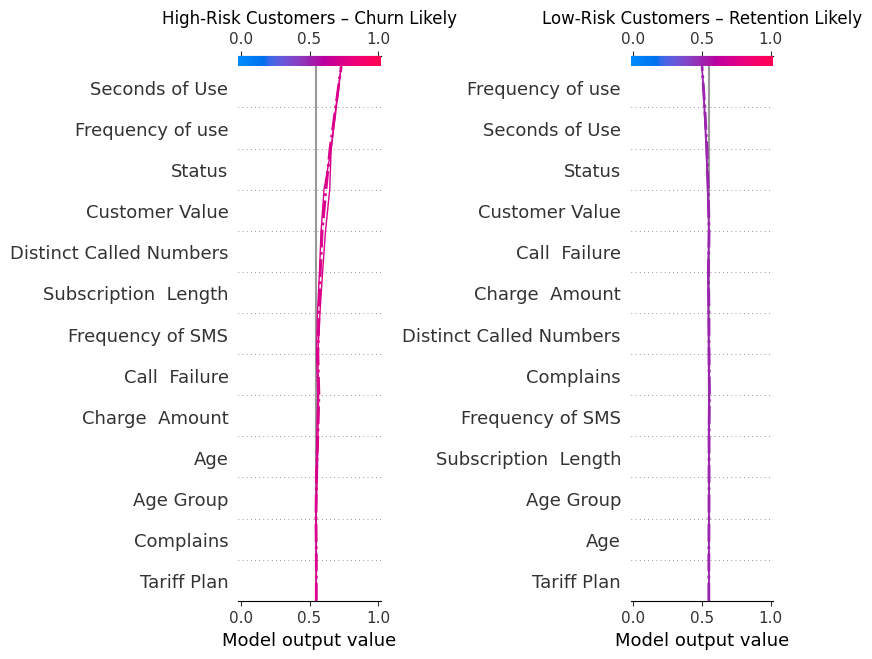

/tmp/ipython-input-1738496421.py:336: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


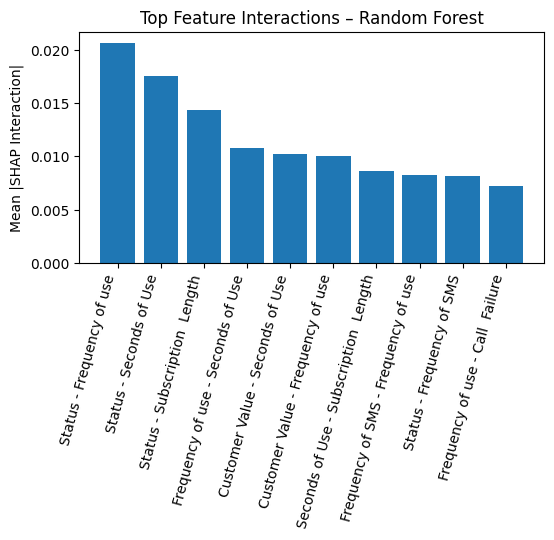

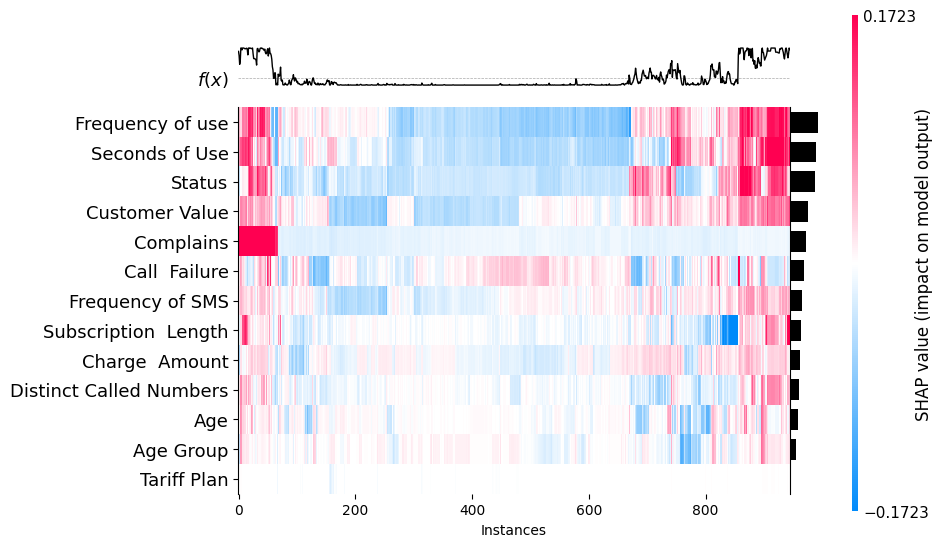

 Interpretation: This plot compares three feature importance methods. MDI = Random Forest's built-in importance, Permutation = model-agnostic effect on performance, SHAP = mean absolute SHAP values. Top features are ranked for clarity.


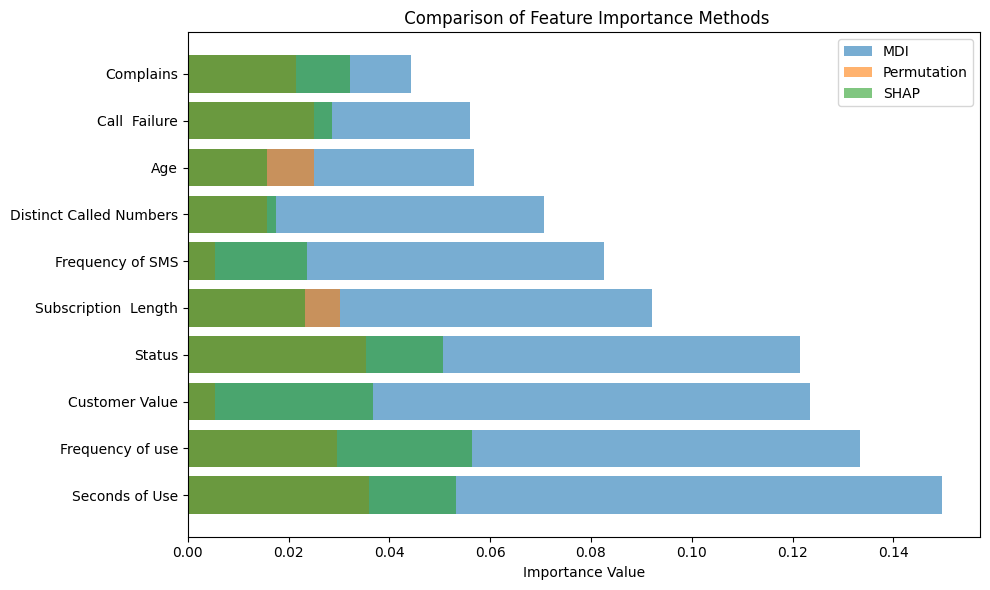

In [3]:
# ==================================================
# 0️⃣ IMPORTS AND INITIAL SETUP
# ==================================================
"""
In this notebook, we’ll explore customer churn using a Random Forest classifier
and interpret the model using SHAP (SHapley Additive exPlanations).

We’ll go beyond accuracy to understand:
- Which features most strongly drive churn predictions
- How each feature contributes positively or negatively
- Interactions between features
- Differences between feature importance methods (MDI, Permutation, SHAP)
"""


import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from google.colab import files
from imblearn.over_sampling import SMOTE

shap.initjs()


print(" Please upload your churn dataset (e.g., Customer Churn.csv)")
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
customer = pd.read_csv(csv_name)

print("\n Preview of uploaded data (first 5 rows):")
print(customer.head())

print("\n We'll predict the 'Churn' column based on customer behavior and service features.")
print("\nTarget class distribution:")
print(customer["Churn"].value_counts())
print(customer["Churn"].value_counts(normalize=True))


X = customer.drop("Churn", axis=1)
y = customer["Churn"]


X_numeric = pd.get_dummies(X)
print(f"\nConverted to numeric format → Shape: {X_numeric.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.3, random_state=1
)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("\nTrain/Test split complete:")
print(f"  → Training samples: {X_train.shape[0]}")
print(f"  → Testing samples: {X_test.shape[0]}")


smote = SMOTE(random_state=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE balancing:")
print(y_train_res.value_counts())


clf = RandomForestClassifier(random_state=1, n_estimators=200)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("\n Model Evaluation (Classification Report):")
print(classification_report(y_test, y_pred))
print(" Accuracy gives performance, but doesn’t tell *why* the model made its decisions — SHAP will help with that next.")



print("\n Computing SHAP values to explain individual predictions...")

explainer = shap.Explainer(clf, X_test)
shap_values = explainer(X_test)

if len(shap_values.values.shape) == 3:
    shap_values_class1 = shap_values.values[:, :, 1]
else:
    shap_values_class1 = shap_values.values

print(f"SHAP values computed for {X_test.shape[0]} samples and {X_test.shape[1]} features.")
print(" Interpretation: Each SHAP value shows how much a feature pushes the prediction toward churn (positive) or retention (negative).")


print("\n Building SHAP DataFrame for detailed inspection...")

shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
shap_df["Base_Value"] = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, np.ndarray)
    else explainer.expected_value
)
shap_df["Predicted_Value"] = shap_df[X_test.columns].sum(axis=1) + shap_df["Base_Value"]
shap_df["Predicted_Probability"] = y_pred_proba

print("\n First 5 rows of SHAP data:")
print(shap_df.head())
print("\n 'Base_Value' is the model’s average prediction before seeing any features. Adding SHAP values shows how each feature changes that baseline for each individual.")


print("\n Global SHAP Summary Plot – How all features influence churn predictions:")
print(" Interpretation: Each dot is a customer. Red = high feature value, blue = low. X-axis shows effect on prediction: right = higher chance of churn, left = lower chance.")


print("\n Class-specific SHAP Summary Plots")

if len(shap_values.values.shape) == 3:

    shap_values_class0 = shap_values.values[:, :, 0]
    shap_values_class1 = shap_values.values[:, :, 1]

    print("\n Summary Plot for Class 0 (No Churn)")
    shap.summary_plot(shap_values_class0, X_test, plot_type="dot", show=True)
    print("Interpretation: Features pushing predictions left (negative SHAP values) support customer retention.")

    print("\n Summary Plot for Class 1 (Churn)")
    shap.summary_plot(shap_values_class1, X_test, plot_type="dot", show=True)
    print("Interpretation: Features pushing predictions right (positive SHAP values) increase churn likelihood.")

else:
    print("Binary classifier detected with single output — only one SHAP summary plot available.")


print("\n Global SHAP Summary – Bar Plot of Mean Absolute SHAP values")
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
shap_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean |SHAP Value|": mean_abs_shap
}).sort_values("Mean |SHAP Value|", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(shap_importance_df["Feature"][:10][::-1], shap_importance_df["Mean |SHAP Value|"][:10][::-1], color='skyblue')
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 10 Features by Average Impact on Churn Prediction (SHAP)")
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print(" Interpretation: Features with higher mean |SHAP Value| have a stronger overall influence on the model’s churn predictions, regardless of direction (positive or negative).")
print(" This complements the dot-summary plot by showing magnitude importance in a clear, ranked bar chart format.")


numeric_features = X_test.select_dtypes(include=[np.number]).columns.tolist()
continuous_features = [f for f in numeric_features if X_test[f].nunique() > 10]

print("\n Creating dependence plots to explore nonlinear effects and feature interactions...")
print(f"Continuous features: {continuous_features}")

for i, feature in enumerate(continuous_features[:3]):
    interaction = continuous_features[(i + 1) % len(continuous_features)]


    shap.dependence_plot(feature, shap_values_class1, X_test, interaction_index=interaction)

    shap.dependence_plot(feature, shap_values_class1, X_test, interaction_index=None)
    print("""
- X-axis = feature value, Y-axis = contribution to churn
- Color shows interacting feature effect
- Nonlinear effects visible (e.g., low Customer Value sharply increases churn risk)
- Business insight: Tailor retention strategies for specific customer segments
""")



idx_high = shap_df["Predicted_Probability"].idxmax()
idx_low = shap_df["Predicted_Probability"].idxmin()

expl_high = shap.Explanation(
    values=shap_values_class1[idx_high],
    base_values=shap_df["Base_Value"].iloc[idx_high],
    data=X_test.iloc[idx_high],
    feature_names=X_test.columns,
)
expl_low = shap.Explanation(
    values=shap_values_class1[idx_low],
    base_values=shap_df["Base_Value"].iloc[idx_low],
    data=X_test.iloc[idx_low],
    feature_names=X_test.columns,
)

print("\n Example 1: Customer predicted *most likely to churn* – waterfall plot shows feature contributions:")
shap.waterfall_plot(expl_high)
print("""
- Positive SHAP values push prediction toward churn; negative values toward retention
- Shows individual customer churn prediction from base value
- Business insight: Use for personalized retention actions
""")


print("\n Example 2: Customer predicted *least likely to churn* – waterfall plot:")
shap.waterfall_plot(expl_low)
print("""
- Features collectively reduced churn probability for this customer
- Arrows right = increase churn, left = decrease churn
- Business insight: Identify customers at low risk to focus resources elsewhere
""")



print("""
- Arrows to the right increase predicted churn, arrows left decrease it
- Shows how individual features push this customer's prediction
""")

print("\n⚡ Force plot for first customer")
shap.plots.force(explainer.expected_value[1], shap_values_class1[0, :], X_test.iloc[0, :], matplotlib=True)
print(" Interpretation: Arrows to the right increase predicted churn, arrows left decrease it.")

print("\n⚡ Force plot for seventh customer")
shap.plots.force(explainer.expected_value[1], shap_values_class1[6, :], X_test.iloc[6, :], matplotlib=True)

print("\n⚡ Force plot for third customer")
shap.plots.force(
    explainer.expected_value[1],
    shap_values_class1[2, :],
    X_test.iloc[2, :],
    matplotlib=True
)
print(" Interpretation: Shows how individual features push this customer's prediction toward churn or retention.")


print("\n Decision Plot – cumulative feature impact for each class")

shap_vals = shap_values.values
base_vals = explainer.expected_value

if shap_vals.ndim == 2:
    shap_vals = shap_vals[:, :, np.newaxis]
    base_vals = [base_vals]

n_classes = shap_vals.shape[2]

if hasattr(clf, "classes_"):
    class_labels = clf.classes_
else:
    class_labels = [f"Class {i}" for i in range(n_classes)]

for class_idx in range(n_classes):
    class_label = class_labels[class_idx]
    print(f"\n⚡ Decision Plot for {class_label}")

    shap.decision_plot(
        base_value=base_vals[class_idx],
        shap_values=shap_vals[:, :, class_idx],
        features=X_test.values,
        feature_names=list(X_test.columns),
        link="logit",
        title=f"Decision Plot – {class_label}",
        show=True
    )

    print(f" Interpretation: For {class_label}, this plot shows how features cumulatively "
          "push predictions from the base value toward that class’s probability.\n")



high3_idx = shap_df["Predicted_Probability"].nlargest(3).index
low3_idx = shap_df["Predicted_Probability"].nsmallest(3).index

shap_high3 = shap_values_class1[high3_idx, :]
X_high3 = X_test.iloc[high3_idx, :]

shap_low3 = shap_values_class1[low3_idx, :]
X_low3 = X_test.iloc[low3_idx, :]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.sca(axes[0])
shap.decision_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_high3,
    features=X_high3,
    highlight=0,
    link="logit",
    show=False
)
axes[0].set_title("High-Risk Customers – Churn Likely")
print(" Interpretation: Cumulative feature impact for top 3 customers most likely to churn.")

plt.sca(axes[1])
shap.decision_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_low3,
    features=X_low3,
    highlight=0,
    link="logit",
    show=False
)
axes[1].set_title("Low-Risk Customers – Retention Likely")
print(" Interpretation: Cumulative feature impact for 3 customers least likely to churn.")

plt.tight_layout()
plt.show()



shap_interactions = shap.TreeExplainer(clf).shap_interaction_values(X_test)
if isinstance(shap_interactions, list):
    shap_interactions_class1 = shap_interactions[1]
else:
    shap_interactions_class1 = shap_interactions

agg_interactions = np.mean(np.abs(shap_interactions_class1), axis=0)

def get_top_k_interactions(feature_names, interaction_matrix, k=10):
    inters = []
    for i in range(len(feature_names)):
        for j in range(i):
            value = interaction_matrix[i, j]
            if isinstance(value, np.ndarray):
                value = value.mean()
            inters.append((f"{feature_names[i]} - {feature_names[j]}", value))
    inters.sort(key=lambda x: x[1], reverse=True)
    feats, vals = zip(*inters[:k])
    return feats, vals

top_feats, top_vals = get_top_k_interactions(X_test.columns, agg_interactions)

plt.figure(figsize=(6, 3))
plt.bar(top_feats, top_vals)
plt.xticks(rotation=75, ha="right")
plt.ylabel("Mean |SHAP Interaction|")
plt.title("Top Feature Interactions – Random Forest")
plt.tight_layout()
plt.show()


print("\n" + "="*50 + "\n")


if len(shap_values.values.shape) == 3:
    shap_values_to_plot = shap_values[..., 1]
else:
    shap_values_to_plot = shap_values.values

expl_full = shap.Explanation(
    values=shap_values_to_plot,
    base_values=(explainer.expected_value[1]
                 if isinstance(explainer.expected_value, np.ndarray)
                 else explainer.expected_value),
    data=X_test,
    feature_names=X_test.columns,
)


num_samples = min(1000, X_test.shape[0])
shap.plots.heatmap(expl_full[:num_samples], max_display=20)


mdi_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": clf.feature_importances_,
    "Type": "MDI"
})

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean,
    "Type": "Permutation"
})

shap_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": np.abs(shap_values_class1).mean(axis=0),
    "Type": "SHAP"
})

all_importances = pd.concat([mdi_importance, perm_df, shap_importance_df])
top_features = all_importances.groupby("Feature")["Importance"].mean().sort_values(ascending=False).head(10).index
filtered = all_importances[all_importances["Feature"].isin(top_features)]

plt.figure(figsize=(10,6))
for imp_type in filtered["Type"].unique():
    subset = filtered[filtered["Type"] == imp_type].sort_values("Importance", ascending=False)
    plt.barh(subset["Feature"], subset["Importance"], label=imp_type, alpha=0.6)
plt.xlabel("Importance Value")
plt.title(" Comparison of Feature Importance Methods")
plt.legend()
plt.tight_layout()
print(" Interpretation: This plot compares three feature importance methods. MDI = Random Forest's built-in importance, Permutation = model-agnostic effect on performance, SHAP = mean absolute SHAP values. Top features are ranked for clarity.")
plt.show()


In [ ]:
!pip install -q imbalanced-learn
